# TP53 Graph Classification - Main Experiment
Predicting TP53 mutation status using single-cell RNA-seq and Graph Neural Networks.


## Setup

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import mygene
sys.path.append(os.path.abspath("../src"))
import importlib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats
import math
from torch_geometric.transforms import LargestConnectedComponents
import torch_geometric.utils as tg_utils
from torch_geometric.data import Data 
import networkx as nx
import torch
import seaborn as sns
import gc
from pathlib import Path



import load_data
import preprocessing
import network_constructor
import model_constructor

## Data import 

In [2]:
adata = load_data.load_expression_data( "../data/Expression_Matrix", verbosity=True)
df_expression=ad.AnnData.to_df(adata)
df_expression.head()


df_expression shape: (35276, 47096)
df_expression columns: Index(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457',
       'ENSG00000000460', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167', 'ENSG00000001460', 'ENSG00000001461',
       'ENSG00000001497',
       ...
       'ENSG00000271681', 'ENSG00000276605', 'ENSG00000277206',
       'ENSG00000277591', 'ENSG00000278658', 'ENSG00000279270',
       'ENSG00000280920', 'ENSG00000283420', 'ENSG00000284003',
       'ENSG00000284685'],
      dtype='object', length=47096)
df_expression head:                     ENSG00000000003  ENSG00000000419  ENSG00000000457  \
AU565_AAACCAGTTTGG              0.0              2.0              0.0   
AU565_AAACGTGCAGCG              1.0              0.0              0.0   
AU565_AAAGCCACATGC              0.0              2.0              0.0   
AU565_AAAGTCGGCTGG              0.0              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0              2.0              0.0   

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,...,ENSG00000271681,ENSG00000276605,ENSG00000277206,ENSG00000277591,ENSG00000278658,ENSG00000279270,ENSG00000280920,ENSG00000283420,ENSG00000284003,ENSG00000284685
AU565_AAACCAGTTTGG,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAACGTGCAGCG,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGCCACATGC,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGTCGGCTGG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGTGCCTAAA,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_mutation = load_data.load_mutation_data("../data/Mutation/CellLineDownload_r21.csv", verbosity=True)
df_mutation = load_data.add_cleaned_column(df_mutation, column_name="Sample_Name")
df_mutation.head()

df_mutation shape: (2913, 80)
df_mutation columns: Index(['Sample_Name', 'ATCC_ID', 'Cosmic_ID', 'Short_topo', 'Morphology',
       'Tumor_origin', 'Add_info', 'Sex', 'Age', 'Country', 'Population',
       'Germline_mutation', 'Infectious_agent', 'Tobacco', 'Alcohol',
       'Exposure', 'KRAS_status', 'Other_mutations', 'TP53status', 'p53_IHC',
       'TP53_LOH', 'MUT_ID', 'hg18_Chr17_coordinates',
       'hg19_Chr17_coordinates', 'hg38_Chr17_coordinates', 'ExonIntron',
       'Codon_number', 'Description', 'Type', 'c_description', 'g_description',
       'g_description_GRCh38', 'WT_nucleotide', 'Mutant_nucleotide',
       'WT_codon', 'Mutant_codon', 'WT_AA', 'Mutant_AA', 'Effect',
       'ProtDescription', 'COSMIClink', 'TCGA_ICGC_GENIE_count', 'Hotspot',
       'AGVGDClass', 'SIFTClass', 'Polyphen2', 'REVEL', 'BayesDel',
       'StructureFunctionClass', 'TransactivationClass', 'DNEclass',
       'DNE_LOFclass', 'WAF1nWT', 'MDM2nWT', 'BAXnWT', 'AIP1nWT', 'h1433snWT',
       'GADD45nWT

,Sample_Name,ATCC_ID,Cosmic_ID,Short_topo,Morphology,Tumor_origin,Add_info,Sex,Age,Country,...,exon3,exon4,exon5,exon6,exon7,exon8,exon9,exon10,exon11,Sample_Name_cleaned
Sample_ID,,,,,,,,,,,,,,,,,,,,,
2946,SW13,CCL-105,909744.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,55.0,NaN,...,False,False,True,True,True,True,False,False,False,SW13
24833,NCI-H295,CRL-10296,908466.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,48.0,NaN,...,False,False,True,True,True,True,False,False,False,NCIH295
24979,NCI-H295R,CRL-2128,NaN,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),primary,Derived from NCI-H295 cell line,F,48.0,NaN,...,True,True,True,True,True,True,True,True,True,NCIH295R
21569,NCI-H295,CRL-10296,908466.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,48.0,NaN,...,True,True,True,True,True,True,True,True,True,NCIH295
21329,ETK-1,NaN,906861.0,BILIARY TRACT,"Adenocarcinoma, NOS",NaN,NaN,F,NaN,NaN,...,True,True,True,True,True,True,True,True,True,ETK1


# EDA and Preprocessing

In [4]:
#Gene mapping
preprocessing.get_genes_symbols(adata, "gene_symbols")
print(adata.var['gene_symbols_mapped'].unique())

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
22 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000227110', 2), ('ENSG00000228566', 2), ('ENSG00000280018', 2), ('E
928 input query terms found no hit:	['ENSG00000112096', 'ENSG00000130723', 'ENSG00000168078', 'ENSG00000189144', 'ENSG00000205485', 'ENS


['TSPAN6' 'DPM1' 'SCYL3' ... 'MIR4278' 'ENSG00000284003' 'ENSG00000284685']


In [5]:
#Add mutation status to adata
preprocessing.add_mutation_column(adata, df_mutation, cell_lines_column_name = "Sample_Name_cleaned", mutation_status_column="TP53status", new_obs_column="mutation_status")

Cell lines not found in df_mutation: ['HS578T' 'MCF12A' 'MX1' 'MDAMB453']
Removed 4562 cells with unknown mutation status.
Number matching lines: 30714
Percentage of matching cell: 87.07%


In [6]:
########################################################################################################################################
########################################################################################################################################
########################################################################################################################################

In [7]:
df_expression.shape

(35276, 47096)

In [8]:
# #TROPPO GRANDE ANCHE PER IL CLUSTER (47096 X 47096)
# tp53_target_path = "../data/Target_genes/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx"
# plot_correlation_comparison(df_expression,tp53_target_path)

In [9]:
########################################################################################################################################
########################################################################################################################################
########################################################################################################################################

In [10]:
#sparsity
preprocessing.check_sparsity(adata)

Number of cells: 30714
Number of genes: 47096
Number of non-zero entries: 100804217
Sparsity: 93.03%


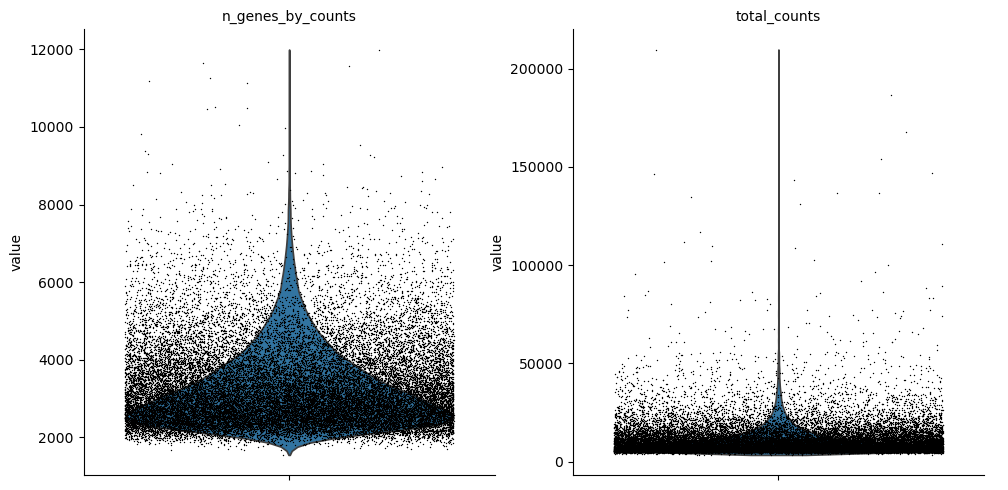

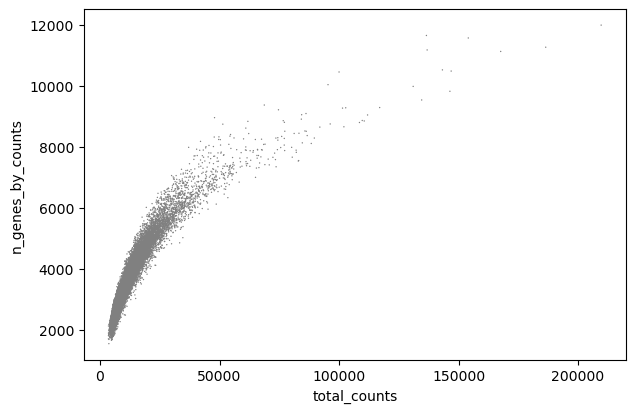

In [11]:
#Quality control
preprocessing.show_qc_plots(adata, violin_cols=['n_genes_by_counts', 'total_counts'], scatter_x='total_counts', scatter_y='n_genes_by_counts')

In [12]:
#dublet detection
sc.pp.scrublet(adata)
print(f"Number of doublets detected: {adata.obs['predicted_doublet'].sum()}")

Number of doublets detected: 0


In [13]:
#Normalization
adata.layers["raw_counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) 

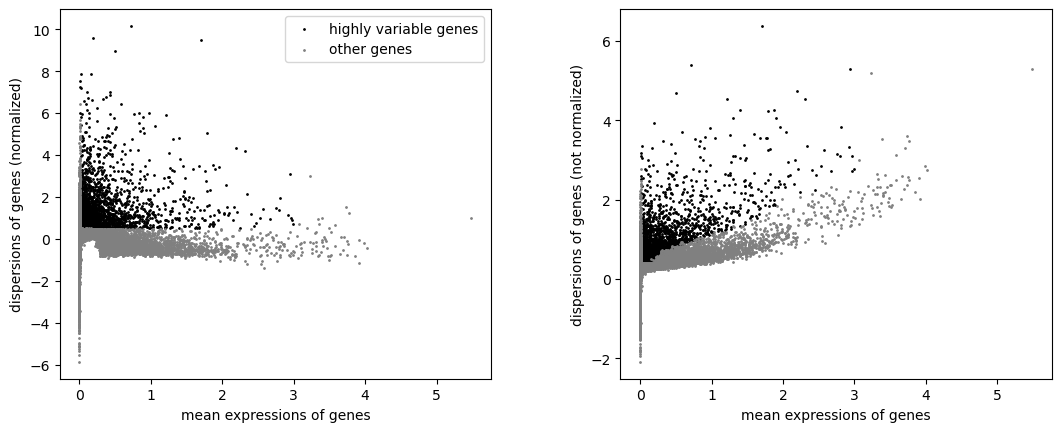

In [14]:
#Feature selection
adata.layers["pre_feature_selection"] = adata.X.copy()

# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=2000)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key="mutation_status")   #AGGIUNGI BATCH KEY
sc.pl.highly_variable_genes(adata, save="hvgs.png")
adata = adata[:, adata.var.highly_variable]

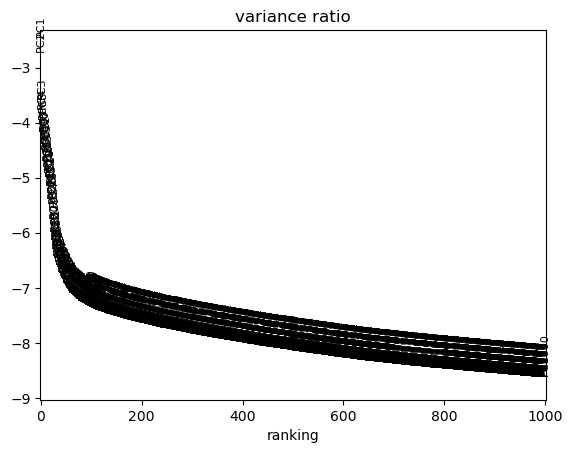

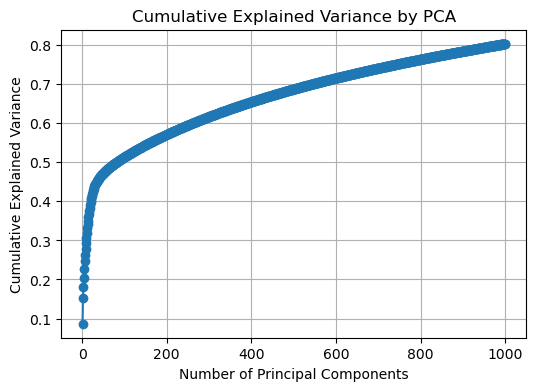

In [39]:
#pca
sc.tl.pca(adata, n_comps=1000)
sc.pl.pca_variance_ratio(adata, n_pcs=1000, log=True)


explained_variance = adata.uns['pca']['variance_ratio']
cumulative_variance = explained_variance.cumsum()


plt.figure(figsize=(6,4))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid(True)
plt.show()


In [16]:
adata.obs['cell_lines'] = adata.obs_names.str.split('_').str[0]

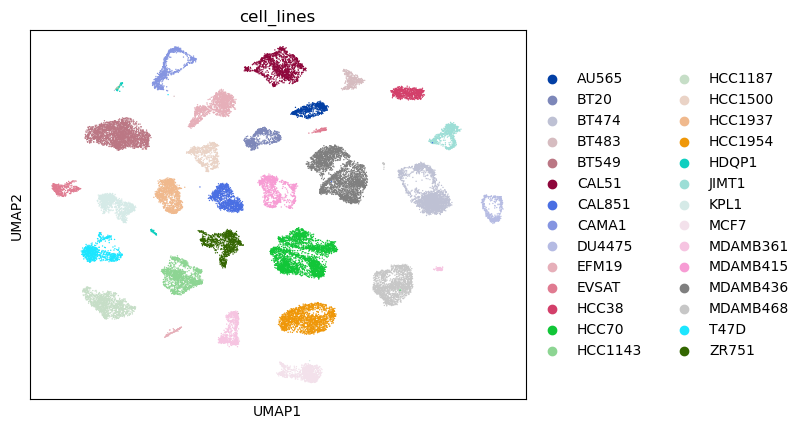

In [17]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = "cell_lines")


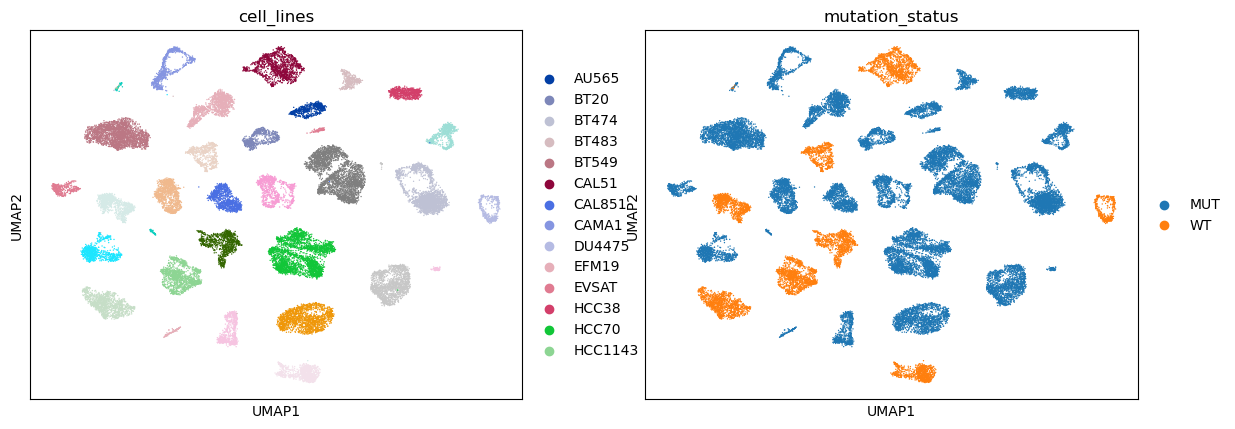

In [36]:
sc.pl.umap(adata, color = ["cell_lines","mutation_status"])

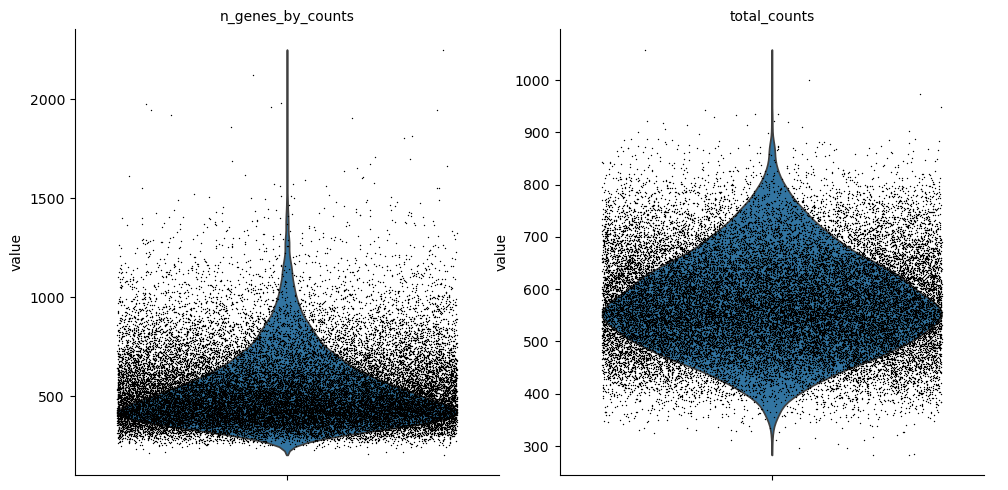

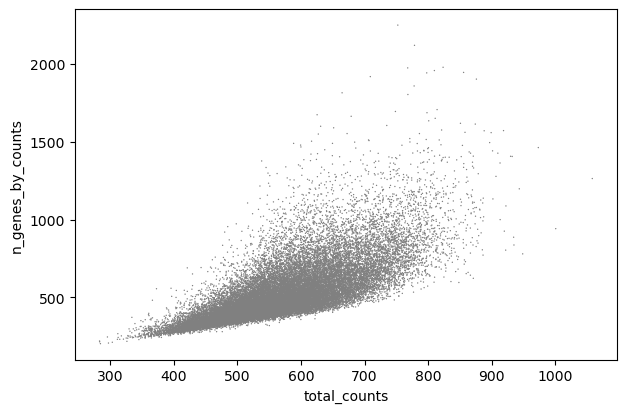

In [18]:
#Final Quality control
preprocessing.show_qc_plots(adata, violin_cols=['n_genes_by_counts', 'total_counts'], scatter_x='total_counts', scatter_y='n_genes_by_counts')

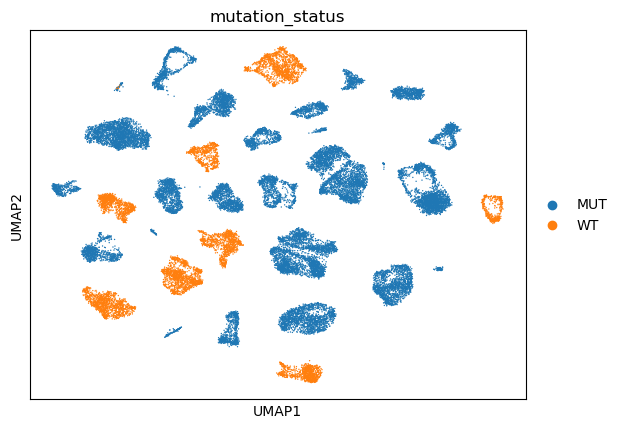

In [19]:
sc.pl.umap(adata, color = "mutation_status")

In [20]:
adata.write("preprocessed_data.h5ad")

In [21]:
final_df = ad.AnnData.to_df(adata)
final_df["mutation_status"] = adata.obs["mutation_status"].values
final_df.head()

,ENSG00000001084,ENSG00000001461,ENSG00000002834,ENSG00000005884,ENSG00000005889,ENSG00000006282,ENSG00000006459,ENSG00000006757,ENSG00000007944,ENSG00000007968,...,ENSG00000164303,ENSG00000236081,ENSG00000165643,ENSG00000188536,ENSG00000137672,ENSG00000248370,ENSG00000147256,ENSG00000164283,ENSG00000285417,mutation_status
AU565_AAACCAGTTTGG,0.0,0.000000,0.0,0.0,0.85499,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MUT
AU565_AAACGTGCAGCG,0.0,0.000000,0.0,0.0,0.00000,0.751924,0.000000,0.751924,0.751924,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MUT
AU565_AAAGCCACATGC,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MUT
AU565_AAAGTCGGCTGG,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.925356,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MUT
AU565_AAAGTGCCTAAA,0.0,0.802482,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MUT


In [22]:
final_df.to_csv("final_preprocessed_data.csv")

# Network Construction

In [3]:
df= pd.read_csv("final_preprocessed_data.csv", index_col=0)
df.head()
df.shape

(30714, 3809)

In [24]:
#Split in train and test set
train_df, test_df = network_constructor.train_test_split(df, test_size=0.2, random_state=42)
print(f"shape del train test: {train_df.shape} \nshape del test set: {test_df.shape}")

shape del train test: (24571, 3809) 
shape del test set: (6143, 3809)


Percentage of non-zero values in the correlation matrix: 0.37581112408198575


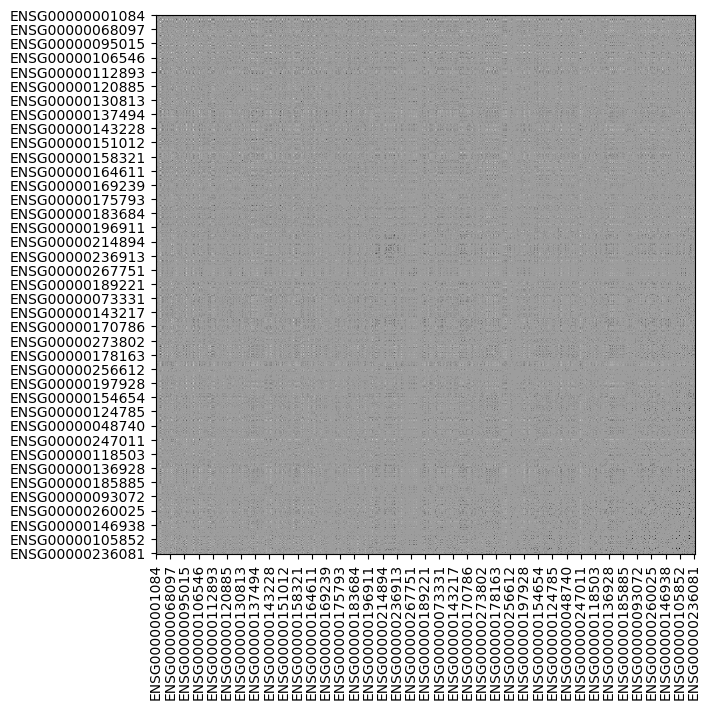

In [25]:
#Construction of the correlation matrix
mat=network_constructor.build_correlation_matrix(train_df.iloc[:,:-1], corr_threshold=0., p_value_threshold= 1) #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat)
network_constructor.plot_the_correlation_matrix(train_df, mat)

In [ ]:
# #COSTRUZIONE DEI GRAFI, LA FACCIAMO SUL CLUSTER QUA NE FACCIAMO SOLO 50 PER TESTARE

# train_df_pyg = network_constructor.create_PyG_graph_from_df(train_df[:50], mat, label_column="mutation_status")
# test_df_pyg = network_constructor.create_PyG_graph_from_df(test_df[:20], mat, label_column="mutation_status")

# #check
# print(f"First element of train_df_pyg: {train_df_pyg[0]}")
# print(f"First element of test_df_pyg: {test_df_pyg[0]}")
# assert network_constructor.check_graph_structure(train_df_pyg), "The graphs in the train set do not have the same structure."
# assert network_constructor.check_graph_structure(test_df_pyg), "The graphs in the test set do not have the same structure."

First element of train_df_pyg: Data(x=[3808, 1], edge_index=[2, 5449586], y=[1])
First element of test_df_pyg: Data(x=[3808, 1], edge_index=[2, 5449586], y=[1])


In [7]:
first_train_batch = torch.load("../data/graphs/train/batch_000.pt", weights_only=False)
first_test_batch = torch.load("../data/graphs/test/batch_000.pt", weights_only=False)

#check
print(f"First element of train_df_pyg: {first_train_batch[0]}")
print(f"First element of test_df_pyg: {first_test_batch[0]}")
assert network_constructor.check_graph_structure(first_train_batch), "The graphs in the train set do not have the same structure."
assert network_constructor.check_graph_structure(first_test_batch), "The graphs in the test set do not have the same structure."

First element of train_df_pyg: Data(x=[3808, 1], edge_index=[2, 3323612], y=[1])
First element of test_df_pyg: Data(x=[3808, 1], edge_index=[2, 3323612], y=[1])


Number of nodes: 3808
Number of edges: 3323612
NUmber of features per node: 1
Has isolated nodes: True
Has self-loops: False
Is undirected: True


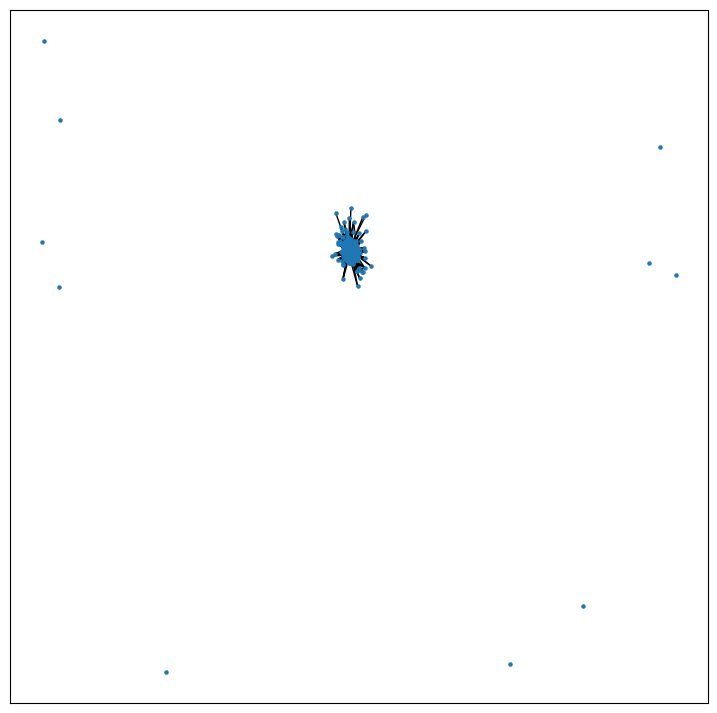

In [8]:
network_constructor.get_info_and_plot_graph(first_train_batch)

# Check on target genes

In [28]:
def plot_frequency_of_correlation_values(matrices, bins=50, alpha=0.5):
    """
    Plot the frequency of correlation values.
    """
    plt.figure(figsize=(10, 6))
    for label,mat in matrices.items():
        values = mat.flatten()
        plt.hist(values, bins=bins, alpha=alpha, label=label, edgecolor='black',density=True)
        mean_val = np.mean(values)
        plt.axvline(mean_val, linestyle='--', linewidth=2)
    plt.yscale('log')
    plt.legend()
    plt.title('Hist of Correlation Values')
    plt.xlabel('Correlation Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

In [29]:
def import_and_create_matrices_for_plotting(path,mat_name,col_name="Ensembl ID",verbosity=False):
    "Expect to have a column named 'Ensembl ID' in the excel file, can specify the name of the columns otherwise with col_name"
    tab = pd.read_excel(path)
    tab_ensembl_ids = [gene for gene in tab[col_name] if gene in df.columns]
    df_tab = df[tab_ensembl_ids].copy()
    mat_tab=network_constructor.build_correlation_matrix(df_tab, corr_threshold=0., p_value_threshold= 1)
    if verbosity==True:
        df_tab.head()
        network_constructor.check_percentage_of_zeros(mat_tab)
    return mat_tab

In [30]:
def plot_correlation_comparison(df_expression,path_list):
    if not isinstance(path_list, list):
        path_list = [path_list]

    
    mat=network_constructor.build_correlation_matrix(df_expression, corr_threshold=0., p_value_threshold= 1)
    
    plot_frequency_of_correlation_values({"Original":mat}, bins=50, alpha=0.5)
    plt.close("all")
    del mat
    gc.collect()
    
    for path in path_list:
        label= path.split("/")[-1].split(".")[0]
        mat = import_and_create_matrices_for_plotting(path, mat_name=label, col_name="Ensembl ID", verbosity=False)
        plot_frequency_of_correlation_values({label:mat}, bins=50, alpha=0.5)
        del mat
        gc.collect()

In [31]:
tab1 = pd.read_excel('../data/Target_genes/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx')
tab1_ensembl_ids = [gene for gene in tab1["Ensembl ID"] if gene in df.columns]
df_tab1 = df[tab1_ensembl_ids].copy()
mat_tab1=network_constructor.build_correlation_matrix(df_tab1, corr_threshold=0., p_value_threshold= 1) #PER ORA NO THRESHOLD
df_tab1.head()
network_constructor.check_percentage_of_zeros(mat_tab1)


Percentage of non-zero values in the correlation matrix: 0.6659315269901281


In [32]:
tab2 = pd.read_excel('../data/Target_genes/41388_2017_BFonc2016502_MOESM6_ESM_tab2.xlsx')
tab2_ensembl_ids = [gene for gene in tab1_ensembl_ids if gene in df.columns]
df_tab2 = df[tab1_ensembl_ids].copy()
mat_tab2=network_constructor.build_correlation_matrix(df_tab2, corr_threshold=0., p_value_threshold= 100) #PER ORA NO THRESHOLD
df_tab2.head()
network_constructor.check_percentage_of_zeros(mat_tab2)

Percentage of non-zero values in the correlation matrix: 0.7690611216131065


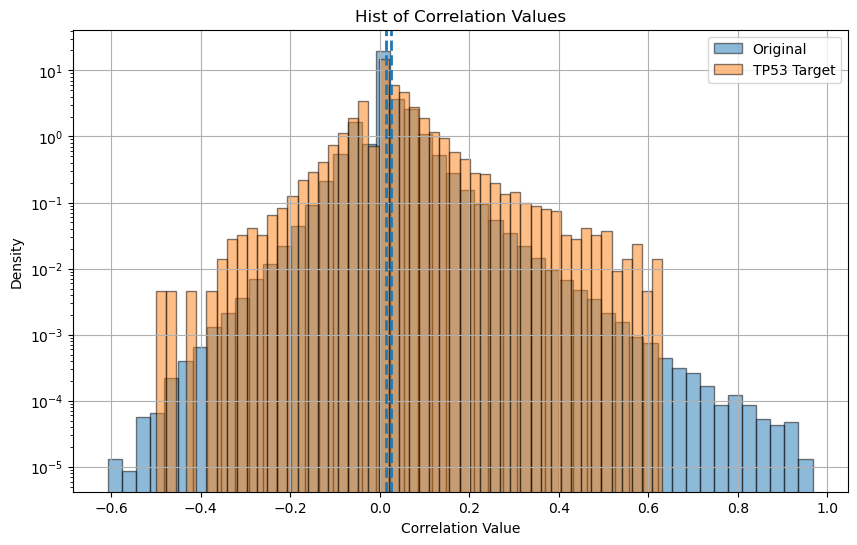

In [33]:
plot_frequency_of_correlation_values({"Original":mat,"TP53 Target":mat_tab1})

In [34]:
from scipy.stats import ks_2samp
stat, pval = ks_2samp(mat.flatten(), mat_tab1.flatten())
print(f"KS: {stat}, p-value: {pval}")

KS: 0.18523917829344938, p-value: 0.0


In [35]:
plot_frequency_of_correlation_values([mat_tab1,mat_tab2])

AttributeError: 'list' object has no attribute 'items'

<Figure size 1000x600 with 0 Axes>

In [ ]:
from scipy.stats import ks_2samp
stat, pval = ks_2samp(mat_tab1.flatten(), mat_tab2.flatten())
print(f"KS statistic: {stat}, p-value: {pval}")

KS statistic: 0.0, p-value: 1.0


# Test to see if the model works

In [ ]:
model = model_constructor.train_model(train_PyG=train_df_pyg, test_PyG=test_df_pyg, epochs = 4, batch_size = 1)

Epoch: 1 | Loss: 0.3262 | Train Acc: 1.0000 | Test Acc: 1.0000
Epoch: 2 | Loss: 0.2011 | Train Acc: 1.0000 | Test Acc: 1.0000
Epoch: 3 | Loss: 0.1686 | Train Acc: 1.0000 | Test Acc: 1.0000
Epoch: 4 | Loss: 0.0844 | Train Acc: 1.0000 | Test Acc: 1.0000
